In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#pandas が DataFrame を表示するとき、最大で 20 行まで表示する設定
pd.set_option('display.max_rows', 20)

dt = pd.read_csv('artists2.csv')
dt["This_year's_Top_MV_goods"] = (
    dt["This_year's_Top_MV_goods"]
    .fillna(dt["This_year's_Top_MV_goods"].median())
)
dt["This_year's_Top_spotify_streams"] = (
    dt["This_year's_Top_spotify_streams"]
    .fillna(dt["This_year's_Top_spotify_streams"].median())
)
#データセットを可視化するには説明変数を2つにしないといけない
X = dt[
    ["This_year's_Top_MV_goods","This_year's_Top_spotify_streams"]].values

y = dt["kohaku_selected"].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

from matplotlib.colors import ListedColormap

# 全体の範囲（train + test 両方を含む）
#vstack➡縦に積む
X_all = sc.inverse_transform(np.vstack([X_train, X_test]))

# メッシュ作成
"""
グラフの平面上に「格子点（チェック柄）」を大量に作ってる。
X1 は横軸（YouTube Good数）の格子
X2 は縦軸（Spotify再生数）の格子
min()-10000 と max()+10000 は「端っこギリギリだと見にくい」ので 余白を足してる。
=500 は「点の細かさ」。小さいほど滑らかだけど計算が重くなる。
meshgrid➡グラフの平面上に、予測させるための“点の網目（マス目）”を作る。
"""
X1, X2 = np.meshgrid(
    np.arange(X_all[:, 0].min() - 10000, X_all[:, 0].max() + 10000, 2000),
    np.arange(X_all[:, 1].min() - 100000, X_all[:, 1].max() + 100000, 2000)
)

# 決定境界の予測
"""
グラフ上の“すべての場所”について「この場所は出る？出
ない？」をAIに答えさせて、その答えを集めている

機械学習が欲しいデータの形は 必ずこれ
1行 = 1データ（1アーティスト）
1列 = 1説明変数
今回なら：[ YouTube Good数 , Spotify再生数 ]

X1 =
[[10, 20, 30],
 [10, 20, 30]]

X2 =
[[100, 100, 100],
 [200, 200, 200]]
ravel() すると？
X1.ravel() → [10, 20, 30, 10, 20, 30]
X2.ravel() → [100,100,100,200,200,200]
np.arrayすると？
[[ 10,  20,  30,  10,  20,  30],   ← Good数
 [100, 100, 100, 200, 200, 200]]  ← 再生数
 .T（転置）すると？
[[10, 100],
 [20, 100],
 [30, 100],
 [10, 200],
 [20, 200],
 [30, 200]]
"""
Z = classifier.predict(
    sc.transform(np.array([X1.ravel(), X2.ravel()]).T)
)
#予測結果の形を戻す（塗り絵できる形に）
#X1 と X2 は「形がまったく同じ」だから、shape を聞く
#代表として X1 を使っている(同じ形でないとcontourfに渡せない)
Z = Z.reshape(X1.shape)

/tmp/ipython-input-1559255595.py:35: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


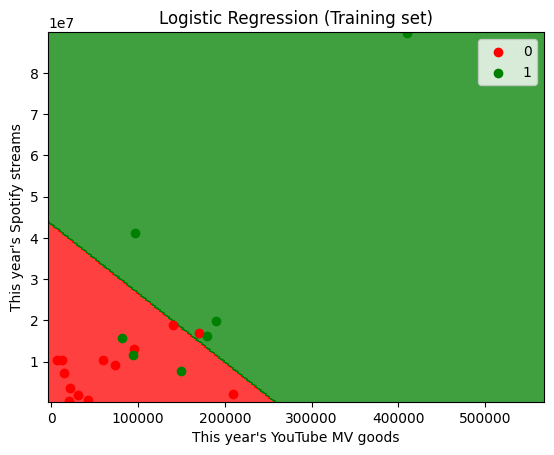

In [8]:
"""
標準化された X_train を、sc が覚えている
平均と標準偏差を使って元の Good数・再生数に戻す
"""
X_set, y_set = sc.inverse_transform(X_train), y_train

# 背景を塗る（決定領域）
#coutorf「等高線とは、地図上で同じ高さ（標高）の地点を結んだ線」
#平面を「予測0なら赤」「予測1なら緑」みたいに塗る。
#alpha=0.75 は透明度（点が見えるように少し透けさせる）
plt.contourf(
    X1, X2, Z,
    alpha=0.75,
    #cmapは色のルール、ListedColormap は色リスト指定
    cmap=ListedColormap(('red', 'green'))
)

# 実データの散布図（本物の点を重ねる）
"""
正解ラベル（0 / 1）ごとに、点を色分けして描く
np.unique(y_set)➡y_set に含まれる 異なる値だけを取り出す
j：ラベルの値（0 or 1）➡ 「どの点を選ぶか」に使う
i：何番目か（0番目、1番目）➡i → 「何色にするか」に使う
unipue➡重複を消して、種類だけ残す[0, 1]
enumerate➡順番番号をつけて取り出す


X_set[y_set == j, 0]
y_set == j
→ 「ラベルが j の行だけ True」
X_set[Trueな行, 0]
→ その行の 0列目（横軸） を取り出す
➡ラベル j の点の X座標（Good数）

c=ListedColormap(('red', 'green'))(i)
(i) をつけると→ i番目の色を取り出す

label=j→凡例（legend）に表示する名前👉 「赤は0」「緑は1」と分かる

"""
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(
        X_set[y_set == j, 0], #X座標の桁をとる
        X_set[y_set == j, 1], #Y座標の桁をとる
        c=ListedColormap(('red', 'green'))(i), #iで色をとる
        label=j
    )

plt.xlabel("This year's YouTube MV goods")
plt.ylabel("This year's Spotify streams")
plt.title("Logistic Regression (Training set)")
plt.legend()
plt.show()
#close() がないと、figure がメモリに残る
plt.close()

"""
ロジスティック回帰を用いて、アーティストが紅白歌合戦に選出されるかどうかを
今年に公開された楽曲のうち、YouTubeで最も多くのいいね数を獲得したMVと、
Spotifyで今年最も再生数が多かった楽曲の再生数という2つの指標から
分類・可視化するモデルを作成した。
説明変数が多いモデルでは決定境界を描くことができないため、
可視化を目的として説明変数を2つに絞った新しいモデルを構築した点が特徴である。

標準化を行った上で学習を行い、その後 inverse_transform を用いて元のスケールに戻すことで、
人間にとって解釈しやすい単位（いいね数・再生数）でグラフを描けるようにした。
meshgrid を用いて平面上の各地点で予測を行い、背景として決定領域を塗り分けることで、
ロジスティック回帰がどのような基準で「出る／出ない」を判断しているのかを視覚的に確認できた。

グラフを見ると、再生数やいいね数が高いにもかかわらず「出ない」と予測されているアーティストや、
その逆に、実際には紅白に出場しているにもかかわらずモデル上では「出ない」と分類されている点が存在した。
この結果から、紅白選出は今年のヒット曲の再生数やMVの人気だけでは測りきれず、
話題性、過去の実績、番組全体の構成など、数値化できていない要因も大きく影響している可能性があると考えた。

また、データ数が少ないことにより、決定境界が単純になりすぎている点も確認できた。
これはモデルの性能というより、入力データの情報量が不足していることに起因すると考えられ、
より多くのデータや、別の指標を追加する必要性を感じた。

さらに、meshgrid による可視化は計算量・メモリ消費が大きく、
コードの書き方によっては実行環境がクラッシュすることも経験した。
そのため、可視化の目的に応じて計算量を抑える工夫を行うことや、
「何を1回だけ計算し、何を使い回すか」を意識してコードを書く重要性も学んだ。

本コードを通じて、ロジスティック回帰の分類結果を
単なる数値評価だけでなく、視覚的に解釈する方法を理解できたと同時に、
モデルの限界やデータ設計の重要性についても考察を深めることができた。

"""

/tmp/ipython-input-175582957.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], c = ListedColormap(('red', 'green'))(i), label = j)


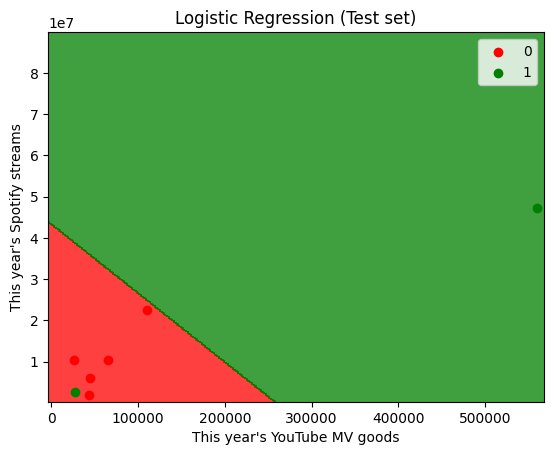

In [9]:
X_set, y_set = sc.inverse_transform(X_test), y_test
plt.contourf(X1, X2, classifier.predict(sc.transform(np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], c = ListedColormap(('red', 'green'))(i), label = j)
plt.xlabel("This year's YouTube MV goods"S)
plt.ylabel("This year's Spotify streams")
plt.title('Logistic Regression (Test set)')
plt.legend()
plt.show()
#close() がないと、figure がメモリに残る
plt.close()